# A2.2 LDA y árboles de decisión


## Base de datos

La base de datos que se utilizará será "auto_mpg_2.csv", la cual fue limpiada para la realización de un proyecto anterior.

El archivo de datos original se puede descargar directamente desde:  
[http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data](http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data)

Este dataset contiene información sobre automóviles de distintos modelos fabricados entre 
1970 y 1982, con variables técnicas y de rendimiento.

---
### Paso 1: Preparación de los datos

En este paso cargamos la base de datos `auto_mpg_2.csv` y definimos como variable
objetivo la columna **`origin_1`**, que corresponde a la clase que deseamos predecir.
Posteriormente, dividimos los datos en conjuntos de entrenamiento y prueba (80% - 20%) 
manteniendo un **balance de clases** mediante estratificación. 

Finalmente, mostramos la distribución de clases antes y después de la división para 
comprobar que se conserva dicho balance.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def print_class_stats(y, title: str):
    """Imprime conteos y proporciones por clase."""
    counts = y.value_counts(dropna=False)
    props  = y.value_counts(normalize=True, dropna=False)
    print(f"\n{title}")
    print("-"*len(title))
    display(pd.DataFrame({"conteo": counts, "proporción": props.round(4)}))

# === Carga de datos ===
df = pd.read_csv("auto_mpg_2.csv")

# Definición de X y y
X = df.drop(columns=["origin_1"])   # variables predictoras
y = df["origin_1"]                  # variable objetivo

# Balance ANTES de dividir
print_class_stats(y, title="Distribución de clases - Dataset completo")

# División train/test estratificada (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# Balance DESPUÉS de dividir
print_class_stats(y_train, title="Distribución de clases - Conjunto de ENTRENAMIENTO")
print_class_stats(y_test,  title="Distribución de clases - Conjunto de PRUEBA")

# Impresiones de confirmación
print("\nResumen de tamaños:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")



Distribución de clases - Dataset completo
-----------------------------------------


,conteo,proporción
origin_1,,
1,245,0.625
0,147,0.375



Distribución de clases - Conjunto de ENTRENAMIENTO
--------------------------------------------------


,conteo,proporción
origin_1,,
1,196,0.6262
0,117,0.3738



Distribución de clases - Conjunto de PRUEBA
-------------------------------------------


,conteo,proporción
origin_1,,
1,49,0.6203
0,30,0.3797



Resumen de tamaños:
X_train: (313, 7), X_test: (79, 7)
y_train: (313,), y_test: (79,)


---
### Paso 2: Regresión Logística con GLM (statsmodels)

En este paso se entrena un modelo de **regresión logística** utilizando la función 
**GLM** de `statsmodels`, tomando todas las variables de entrada (`X_train`) 
para predecir la variable objetivo **`origin_1`**.

Posteriormente, se imprime el **resumen del modelo**, donde se pueden observar 
los coeficientes, errores estándar y niveles de significancia de cada variable.  
De este resumen se seleccionarán las **2 variables más relevantes**. En este caso, se decidirá mediante los p-value más bajos.  

Finalmente, actualizamos los conjuntos de entrenamiento y prueba para conservar 
únicamente estas 2 variables seleccionadas.


In [2]:
import statsmodels.api as sm

# Agregamos constante al conjunto de entrenamiento (intercepto)
X_train_sm = sm.add_constant(X_train)

# Definición del modelo GLM (regresión logística)
modelo_glm = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
resultado_glm = modelo_glm.fit()

# Mostrar resumen en consola
print(resultado_glm.summary())

# Aquí tomamos las dos variables con menor p-value
p_values = resultado_glm.pvalues.drop("const")  # excluimos la constante
variables_relevantes = p_values.nsmallest(2).index.tolist()

print("\nVariables seleccionadas como más relevantes:")
print(variables_relevantes)

# Filtramos X_train y X_test con solo esas variables
X_train_sel = X_train[variables_relevantes]
X_test_sel = X_test[variables_relevantes]

print("\nNuevas dimensiones después de la selección:")
print(f"X_train_sel: {X_train_sel.shape}, X_test_sel: {X_test_sel.shape}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:               origin_1   No. Observations:                  313
Model:                            GLM   Df Residuals:                      305
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -79.699
Date:                Thu, 02 Oct 2025   Deviance:                       159.40
Time:                        00:19:15   Pearson chi2:                     170.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5563
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -7.7811      5.728     -1.358   

---
### Paso 3: Linear Discriminant Analysis (LDA)

Entrenamos un modelo **LDA** con las **dos variables** seleccionadas en el Paso 2 `displacemente` y `weight`.  
Se estandarizan únicamente con estadísticas del conjunto de entrenamiento y se visualiza la **frontera de decisión** junto con los puntos de entrenamiento.


Score (train) LDA: 0.8083067092651757


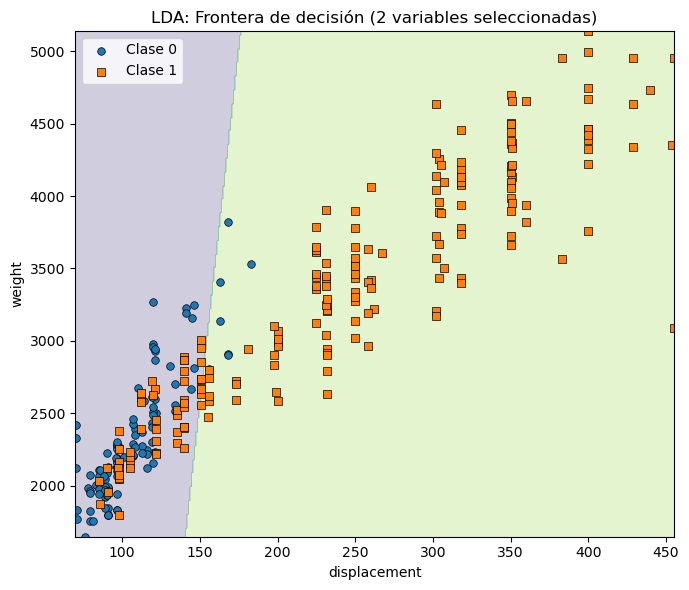

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# --- 1) Estandarización (fit con train, transform en train/test) ---
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_sel),
    columns=X_train_sel.columns,
    index=X_train_sel.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_sel),
    columns=X_test_sel.columns,
    index=X_test_sel.index
)

# --- 2) LDA (entrena con datos escalados) ---
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
print("Score (train) LDA:", lda.score(X_train_scaled, y_train))

# --- 3) Malla en el plano (ejes en escala ORIGINAL, predicción con datos escalados) ---
x0_name, x1_name = X_train_sel.columns.tolist()
x0_min, x0_max = X_train_sel[x0_name].min() - 0.5, X_train_sel[x0_name].max() + 0.5
x1_min, x1_max = X_train_sel[x1_name].min() - 0.5, X_train_sel[x1_name].max() + 0.5

xx0, xx1 = np.meshgrid(
    np.linspace(x0_min, x0_max, 400),
    np.linspace(x1_min, x1_max, 400)
)

grid_orig = pd.DataFrame(
    np.c_[xx0.ravel(), xx1.ravel()],
    columns=[x0_name, x1_name]
)
grid_scaled = pd.DataFrame(
    scaler.transform(grid_orig),
    columns=[x0_name, x1_name]
)

Z = lda.predict(grid_scaled).reshape(xx0.shape)

# --- 4) Gráfica: regiones + puntos de entrenamiento (en escala original) ---
plt.figure(figsize=(7, 6))
plt.contourf(xx0, xx1, Z, alpha=0.25, levels=len(np.unique(y_train)))

classes = np.unique(y_train)
markers = ['o', 's', '^', 'D', 'X', 'P']
for i, c in enumerate(classes):
    mask = (y_train == c)
    plt.scatter(
        X_train_sel.loc[mask, x0_name],
        X_train_sel.loc[mask, x1_name],
        s=30, edgecolor='k', linewidth=0.5,
        marker=markers[i % len(markers)],
        label=f"Clase {c}"
    )

plt.title("LDA: Frontera de decisión (2 variables seleccionadas)")
plt.xlabel(x0_name)
plt.ylabel(x1_name)
plt.legend()
plt.tight_layout()
plt.show()


---
### Paso 4: Árbol de Decisión con Poda (LOOCV)

En este paso entrenamos un **árbol de decisión** usando las 2 variables seleccionadas.  
Se utiliza **validación cruzada leave-one-out (LOOCV)** para encontrar el valor óptimo del 
parámetro de complejidad `ccp_alpha`, se poda el árbol y se visualizan:

1. El árbol resultante.  
2. La partición de decisión en el plano de las dos variables.  


Mejor alpha (LOOCV): 0.010687 | Accuracy CV: 0.9073
Accuracy (train) con árbol podado: 0.9137


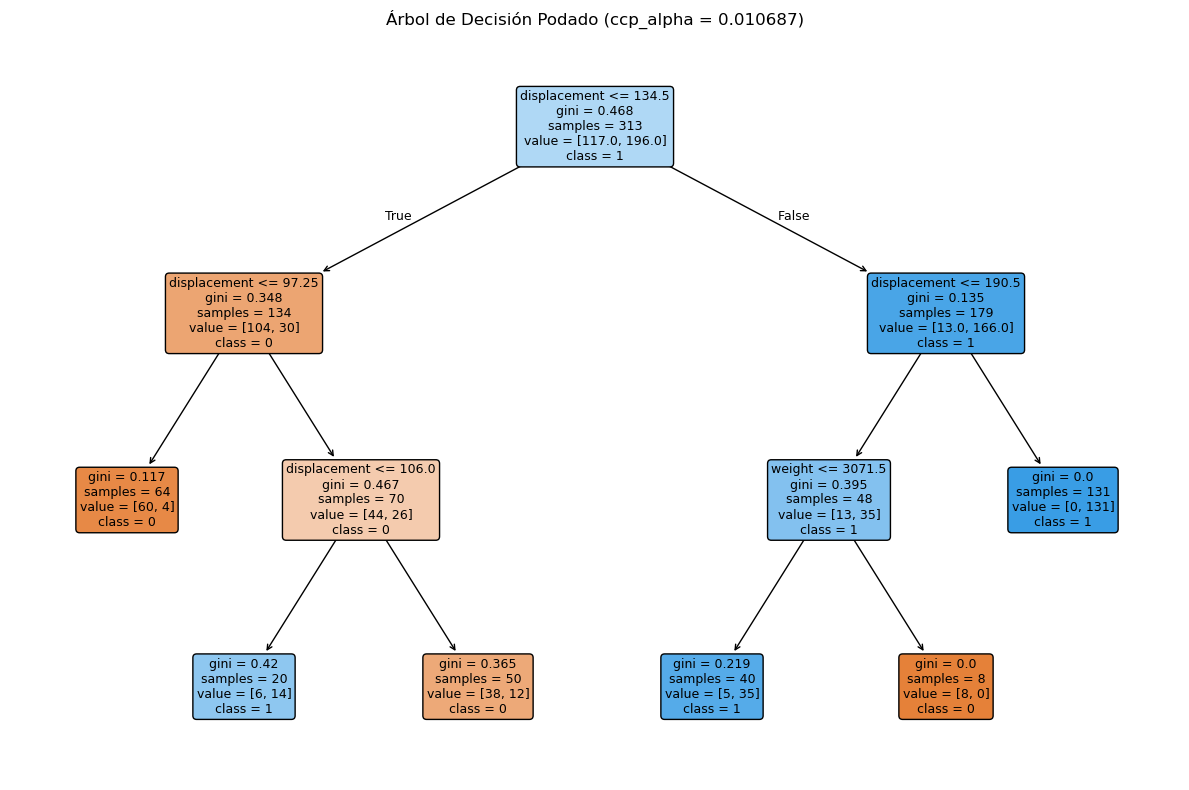

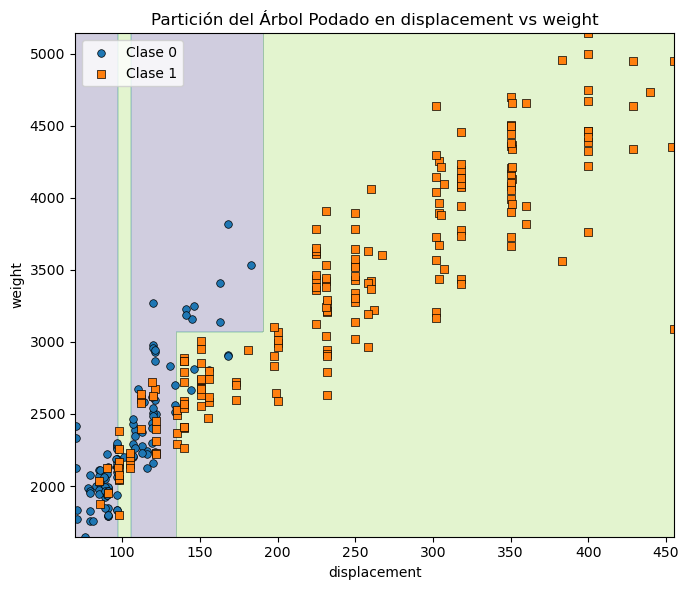

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import accuracy_score

# Nombres de las dos variables seleccionadas en Paso 2
feat_names = X_train_sel.columns.tolist()
x0_name, x1_name = feat_names

# --------- 1) Ruta de poda para generar candidatos de ccp_alpha ---------
base_tree = DecisionTreeClassifier(random_state=42)
path = base_tree.cost_complexity_pruning_path(X_train_sel, y_train)

# Alphas únicos y ordenados (removemos el último, que suele colapsar el árbol a la raíz)
alphas = np.unique(path.ccp_alphas)
if len(alphas) > 1:
    alphas = alphas[:-1]
if len(alphas) == 0:
    alphas = np.array([0.0])

# --------- 2) LOOCV (Leave-One-Out) para elegir el mejor alpha ---------
loo = LeaveOneOut()
cv_scores = []

for a in alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=a)
    # Accuracy con LOOCV (predicción de clase)
    scores = cross_val_score(clf, X_train_sel, y_train, cv=loo, scoring='accuracy')
    cv_scores.append(scores.mean())

cv_scores = np.array(cv_scores)
best_cv = cv_scores.max()
best_idx = np.where(cv_scores == best_cv)[0]
# En empate, preferimos el árbol más simple (alpha más grande)
best_alpha = alphas[best_idx].max()

print(f"Mejor alpha (LOOCV): {best_alpha:.6f} | Accuracy CV: {best_cv:.4f}")

# --------- 3) Entrenar árbol definitivo (podado) con alpha óptimo ---------
tree_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
tree_pruned.fit(X_train_sel, y_train)

print(f"Accuracy (train) con árbol podado: {tree_pruned.score(X_train_sel, y_train):.4f}")

# --------- 4) Visualización del árbol podado ---------
plt.figure(figsize=(12, 8))
plot_tree(
    tree_pruned,
    feature_names=feat_names,
    class_names=[str(c) for c in np.unique(y_train)],
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title(f"Árbol de Decisión Podado (ccp_alpha = {best_alpha:.6f})")
plt.tight_layout()
plt.show()

# --------- 5) Visualización de la partición (frontera de decisión) en 2D ---------
# Rango de los ejes (escala ORIGINAL de las 2 variables seleccionadas)
x0_min, x0_max = X_train_sel[x0_name].min() - 0.5, X_train_sel[x0_name].max() + 0.5
x1_min, x1_max = X_train_sel[x1_name].min() - 0.5, X_train_sel[x1_name].max() + 0.5

xx0, xx1 = np.meshgrid(
    np.linspace(x0_min, x0_max, 400),
    np.linspace(x1_min, x1_max, 400)
)

grid_df = pd.DataFrame(np.c_[xx0.ravel(), xx1.ravel()], columns=[x0_name, x1_name])
Z = tree_pruned.predict(grid_df).reshape(xx0.shape)

plt.figure(figsize=(7, 6))
# Región de decisión
plt.contourf(xx0, xx1, Z, alpha=0.25, levels=len(np.unique(y_train)))

# Puntos de entrenamiento por clase (con estilo distinto)
classes = np.unique(y_train)
markers = ['o', 's', '^', 'D', 'X', 'P']
for i, c in enumerate(classes):
    mask = (y_train == c)
    plt.scatter(
        X_train_sel.loc[mask, x0_name],
        X_train_sel.loc[mask, x1_name],
        s=30, edgecolor='k', linewidth=0.5,
        marker=markers[i % len(markers)],
        label=f"Clase {c}"
    )

plt.title(f"Partición del Árbol Podado en {x0_name} vs {x1_name}")
plt.xlabel(x0_name)
plt.ylabel(x1_name)
plt.legend()
plt.tight_layout()
plt.show()


### Paso 5: Métricas de evaluación en prueba (LDA vs Árbol podado)

Calculamos en el *test set* las métricas vistas en clase:

- **Matriz de confusión** (TP, FP, TN, FN).
- **Accuracy**: \((TP + TN)/(TP + TN + FP + FN)\).
- **Sensitivity**: \(TP/(TP + FN)\).
- **Specificity**: \(TN/(TN + FP)\).
- **Precision**: \(TP/(TP + FP)\).
- **F1-score**: media armónica entre *precision* y *sensibilidad*.

> Reportamos cada métrica para **LDA** y para el **Árbol de Decisión podado**.
> Usamos `origin_1 = 1` como clase positiva (positivo binario).


In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# --- Predicciones en test ---
# LDA usa variables estandarizadas (del Paso 3)
y_pred_lda   = lda.predict(X_test_scaled)

# Árbol podado usa variables en escala original (del Paso 4 reiniciado)
y_pred_tree  = tree_pruned.predict(X_test_sel)

# --- Función utilitaria: métricas a partir de la matriz de confusión ---
def metrics_from_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()

    total = TP + TN + FP + FN
    accuracy    = (TP + TN) / total if total else 0.0
    sensitivity = TP / (TP + FN)   if (TP + FN) else 0.0  
    specificity = TN / (TN + FP)   if (TN + FP) else 0.0
    precision   = TP / (TP + FP)   if (TP + FP) else 0.0
    f1          = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) else 0.0

    return {
        "confusion_matrix": cm,
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1": f1
    }

# --- Cálculo de métricas ---
m_lda  = metrics_from_confusion(y_test, y_pred_lda)
m_tree = metrics_from_confusion(y_test, y_pred_tree)

# --- Impresión formateada ---
def print_report(nombre, m):
    print(f"\n=== {nombre} ===")
    print("Matriz de confusión  ->  [[TN, FP], [FN, TP]]")
    print(m["confusion_matrix"])
    print(f"Accuracy:     {m['accuracy']*100:6.2f}%")
    print(f"Sensitivity:  {m['sensitivity']*100:6.2f}%")
    print(f"Specificity:  {m['specificity']*100:6.2f}%")
    print(f"Precision:    {m['precision']*100:6.2f}%")
    print(f"F1-score:     {m['f1']*100:6.2f}%")

print_report("LDA (test)", m_lda)
print_report("Árbol podado (test)", m_tree)

# --- Cuadro comparativo (opcional) ---
df_compare = pd.DataFrame({
    "Modelo": ["LDA", "Árbol podado"],
    "Accuracy":    [m_lda["accuracy"],    m_tree["accuracy"]],
    "Sensitivity": [m_lda["sensitivity"], m_tree["sensitivity"]],
    "Specificity": [m_lda["specificity"], m_tree["specificity"]],
    "Precision":   [m_lda["precision"],   m_tree["precision"]],
    "F1-score":    [m_lda["f1"],          m_tree["f1"]],
})
display(df_compare.round(4))



=== LDA (test) ===
Matriz de confusión  ->  [[TN, FP], [FN, TP]]
[[29  1]
 [ 9 40]]
Accuracy:      87.34%
Sensitivity:   81.63%
Specificity:   96.67%
Precision:     97.56%
F1-score:      88.89%

=== Árbol podado (test) ===
Matriz de confusión  ->  [[TN, FP], [FN, TP]]
[[25  5]
 [ 2 47]]
Accuracy:      91.14%
Sensitivity:   95.92%
Specificity:   83.33%
Precision:     90.38%
F1-score:      93.07%


,Modelo,Accuracy,Sensitivity,Specificity,Precision,F1-score
0,LDA,0.8734,0.8163,0.9667,0.9756,0.8889
1,Árbol podado,0.9114,0.9592,0.8333,0.9038,0.9307



Los resultados en el conjunto de prueba muestran diferencias importantes entre los dos modelos:

#### LDA (Linear Discriminant Analysis)
- **Accuracy**: 87.34%  
- **Sensitivity**: 81.63%  
- **Specificity**: 96.67%  
- **Precision**: 97.56%  
- **F1-score**: 88.89%  

Este modelo tiene **muy alta especificidad y precisión**, lo que significa que es excelente para identificar correctamente a la clase negativa (evita falsos positivos) y sus predicciones positivas son muy confiables.  
Sin embargo, debido a su sensibilidad es más baja, lo que implica que deja escapar varios casos positivos (falsos negativos). 
En pocas palabras, tiene una tendencia a poner negativos independientemente.


#### Árbol de Decisión Podado
- **Accuracy**: 91.14%  
- **Sensitivity**: 95.92%  
- **Specificity**: 83.33%  
- **Precision**: 90.38%  
- **F1-score**: 93.07%  

El árbol podado ofrece **mayor sensibilidad y F1-score**, lo que significa que detecta casi todos los positivos y logra un balance más uniforme entre precisión y sensibilidad.  
Aunque su especificidad es más baja (más falsos positivos), compensa con un mejor equilibrio global en las métricas.
En pocas palabras, tiene una tendencia a poner positivos independientemente.

---

### Conclusión
- **LDA** es mejor si la prioridad es **evitar falsos positivos** y tener alta precisión.  
- **Árbol podado** es mejor si la prioridad es **detectar la mayor cantidad de positivos posibles** y lograr un **mejor rendimiento global** (según F1 y accuracy).  

En esta tarea específica, considero que el **Árbol de Decisión Podado** es **superior**, ya que maximiza la detección de positivos (siendo los carros de Estados Unidos los "positivos" y teniendo una mayor cantidad de ellos, considero que tiene algo de importancia priorizar a estos) y mantiene un F1-score más alto, lo cual nos indica que detecta casi todos los positivos sin perder demasiada precisión, resultando al menos más equilibrado que el modelo de LDA.

**Ganador seleccionado: Arbol Podado**
